In [3]:
import numpy as np
n_init = 20
n_total = 60
alpha_list = [1.96, 1.96]
true_param = np.array([0.2,0.8]).reshape(1,2)

### References:
BandCamp Notebook (Derek Everett):   
https://github.com/derekeverett/simple_bayes_with_GP/blob/master/BANDCamp2020_Bayes_Param_Est_GP.ipynb  

Emulator with noise:  
https://gpy.readthedocs.io/en/deploy/GPy.likelihoods.html#module-GPy.likelihoods.gaussian  

ptemcee:  
https://emcee.readthedocs.io/en/develop/user/pt/

Plotting contours:  
https://stackoverflow.com/questions/45043833/curve-defined-by-the-intersection-between-two-scattered-point-surfaces-sampled  


In [4]:
import emcee
from scipy.optimize import minimize
import corner
import ptemcee
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from emukit.core import ParameterSpace, ContinuousParameter
from GPy.models import MultioutputGP
from GPy import likelihoods
from emukit.model_wrappers import GPyMultiOutputWrapper
from GPy.kern import RBF, White
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

import random
random.seed(42)

from emukit.experimental_design.acquisitions.contour_MultiObs_min import contourMinEI
from emukit.experimental_design.acquisitions.contour_1D import contour1D
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.core.optimization import GradientAcquisitionOptimizer

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pyDOE import *
from scipy.stats import norm
from scipy import integrate
import corner

import math
%matplotlib inline 

from emcee.ptsampler import PTSampler

In [5]:
# 3d plot function
def makeplot(position,x,y,z,title):
    ax = fig.add_subplot(position,projection='3d')
    ax.scatter(x, y, z, label=title)
    ax.legend()
    return ax

### Define Test Functions

[array([[3.98846086]]), array([[43.29208585]])]
[array([[3.95652513]]), array([[43.33242461]])]


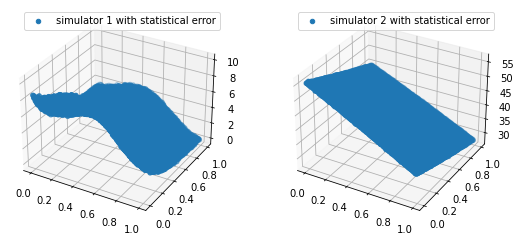

In [7]:
lb = [0,0]
ub = [1,1]
parameter_space = ParameterSpace([ContinuousParameter('x1', lb[0], ub[0]),ContinuousParameter('x2', lb[1], ub[1])])
pi = math.pi
a = 1
b = 5.1 / (4 * pi **2)
c = 5 / pi
r = 6
s = 10
t = 1 / (8*pi)
noise = 0.1 # statistical noise

# https://www.sfu.ca/~ssurjano/limetal02non.html
# https://www.sfu.ca/~ssurjano/branin.html

def f(X): # with statistical noise
    y1 = 1/6 * ((30+5*X[:,0]*np.sin(5*X[:,0])) * (4+np.exp(-5*X[:,1]))-100) +  np.random.normal(0,noise,X.shape[0])
    y2 = a * (X[:,1] - b * X[:,0]**2 + c * X[:,0] - r)**2 + s*(1-t) * np.cos(X[:,0]) + s +  np.random.normal(0,noise,X.shape[0])
    return [y1.reshape(-1,1),y2.reshape(-1,1)]

def f_noNoise(X): # noise-free
    y1 = 1/6 * ((30+5*X[:,0]*np.sin(5*X[:,0])) * (4+np.exp(-5*X[:,1]))-100)
    y2 = a * (X[:,1] - b * X[:,0]**2 + c * X[:,0] - r)**2 + s*(1-t) * np.cos(X[:,0]) + s
    return [y1.reshape(-1,1),y2.reshape(-1,1)]

# for plotting contours
def l(x, y):
    return 1/6 * ((30+5*x*np.sin(5*x)) * (4+np.exp(-5*y))-100)

def g(x, y):
    return a * (y - b * x**2 + c * x - r)**2 + s*(1-t) * np.cos(x) + s

a_list = f_noNoise(true_param)
w_list = [0.5, 0.5] # not in use for minEI criterion

print(a_list)
print(f(true_param))

axis1 = np.arange(lb[0], ub[0], 0.01)
axis2 = np.arange(lb[1], ub[1], 0.01)

B, D = np.meshgrid(axis1, axis2)
X_plot = np.array([B.flatten(),D.flatten()]).transpose()

# side by side 3d plot
fig = plt.figure(figsize=(9,4))
makeplot(121, B.flatten(), D.flatten(), f(X_plot)[0].flatten(), 'simulator 1 with statistical error')
makeplot(122, B.flatten(), D.flatten(), f(X_plot)[1].flatten(), 'simulator 2 with statistical error')
plt.show()


### Set experimental data & uniform prior

In [5]:
y_exp = np.array(a_list).flatten().reshape(1,2) # oracle target
dy_exp = np.array([[0.1,0.1]]) # experimental noise (fixed)

In [6]:
theta_min = 0
theta_max = 1
ndim = len(a_list)

# independent uniform prior
def log_flat_prior(theta):
    # The parameters are stored as a vector of values, so unpack them
    theta1, theta2 = theta
    # We're using only uniform priors in [0,1]
    if (theta_min <= theta1) and (theta1 <= theta_max) and (theta_min <= theta2) and (theta2 <= theta_max):
        return 0. # log(1)
    else:
        return -np.inf  # log(0)
    
# log_flat_prior = np.vectorize(log_flat_prior)

### 1. Target posterior (using simulator directly)

In [7]:
def sim_output(xx, obsno):
    """This generates output from simulator."""
    X = xx.reshape(-1, ndim)
    y = f(X)[obsno]
    return y

# define log likelihood
def log_likelihood_sim(theta, y_exp, dy_exp):
    '''Log-likelihood for data y_exp.'''
    #use our GP emulator for prediction
    log_lik = 0
    
    for obs in range(y_exp.shape[1]): # number of observables
        y_pred = sim_output(theta, obs) # simulator, no simulator uncertainty
        sigma2 = dy_exp.flatten()[obs]**2. 
        log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) -0.5*( (y_pred - y_exp.flatten()[obs])**2 / sigma2 )
        
    return log_lik

#posterior using flat prior
def log_posterior_flat_prior_sim(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is flat.'''
    return log_flat_prior(theta) + log_likelihood_sim(theta, y_exp, dy_exp)

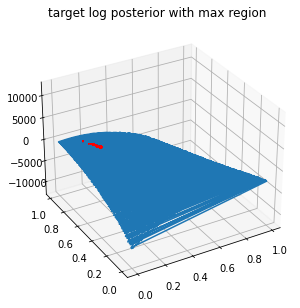

In [8]:
# plot target log posterior
axis1 = np.arange(lb[0], ub[0], 0.01)
axis2 = np.arange(lb[1], ub[1], 0.01)

B, D = np.meshgrid(axis1, axis2)
X_plot = np.array([B.flatten(),D.flatten()]).transpose()

target_logposterior = [log_posterior_flat_prior_sim(x, y_exp, dy_exp) for x in X_plot]
tlp = np.array(target_logposterior).flatten()

fig = plt.figure(figsize = (5,5))
ax = fig.gca(projection='3d')
ax.plot(B.flatten(), D.flatten(), tlp)
ax.contour(B, D, np.abs(tlp-max(tlp)).reshape(D.shape[0],D.shape[1]), levels=list(np.linspace(0,1,100)),\
           zdir='z', offset=0, colors='red')
plt.title('target log posterior with max region')
ax.view_init(30, 240)
plt.show()

# # export data to check logposterior (note: cannot use f() to compare, different noise, here we only compare when f is replaced by f_noNoise in sim_output function)
# x_toR = pd.DataFrame(X_plot)
# x_toR.to_csv('sim_calc_logposterior_x.csv', index=False)
# y_toR = pd.DataFrame(np.array([f_noNoise(X_plot)[0].flatten(),f_noNoise(X_plot)[1].flatten()]).T)
# y_toR.to_csv('sim_calc_logposterior_y.csv', index=False)
# tlp_toR = pd.DataFrame(tlp)
# tlp_toR.to_csv('sim_calc_logposterior.csv', index=False)

In [9]:
# ptemcee
ntemps = 2
nwalkers = 20
# starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
starting_guesses = np.random.uniform(size=(ntemps,nwalkers,ndim))
sampler = PTSampler(nwalkers, ndim, log_likelihood_sim, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp])

# burn in
for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=5000):
    pass
sampler.reset()

# record every 10
for p, lnprob, lnlike in sampler.sample(p, iterations=1000, thin=10):
    pass

# resulting chains
assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

# Longest autocorrelation length (over any temperature)
max_acl = np.max(sampler.acor)

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

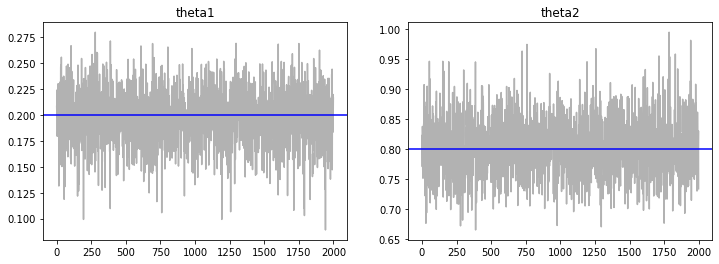

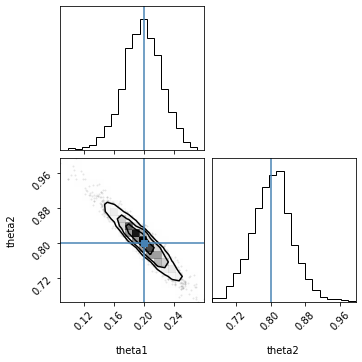

In [10]:
# plots & save data for R analysis
sim_T0chain = sampler.chain[0,...].reshape(-1,ndim)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(sim_T0chain[:,0], '-', color='k', alpha=0.3)
ax1.axhline(y=true_param[0][0], color='blue')
ax1.title.set_text('theta1')

ax2.plot(sim_T0chain[:,1], '-', color='k', alpha=0.3)
ax2.axhline(y=true_param[0][1], color='blue')
ax2.title.set_text('theta2')
plt.show()

tmp = corner.corner(sim_T0chain, labels=['theta1','theta2'], 
                truths=[true_param[0][0],true_param[0][1]])

MCMC_sim = pd.DataFrame(sim_T0chain)
MCMC_sim.to_csv('2d_2obs_Branin_LIM_MCMCsim.csv', index=False)

### 2. Proposed Sequential Design Method (acquisition with no noise)

#### Repeat 10 times

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


[array([[0.08591744, 1.        ]]), array([[0.07404397]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[array([[0.08021345, 1.        ]]), array([[0.06257634]])]
[array([[0.08087267, 1.        ]]), array([[0.05289374]])]
[array([[0.08167326, 1.        ]]), array([[0.04739894]])]
[array([[0.08694124, 0.99174568]]), array([[0.04268901]])]
[array([[0.21997771, 0.76783112]]), array([[0.04631121]])]
[array([[0.08678266, 0.99376137]]), array([[0.04517622]])]
[array([[0.25929908, 0.69854825]]), array([[0.04236456]])]
[array([[0.1066901 , 0.96272489]]), array([[0.03965612]])]
[array([[0.25277103, 0.71027285]]), array([[0.03821638]])]
[array([[0.12142621, 0.93798917]]), array([[0.03760932]])]
[array([[0.24472784, 0.72567203]]), array([[0.03852717]])]
[array([[0.16261139, 0.86890574]]), array([[0.03596263]])]
[array([[0.24473514, 0.72635436]]), array([[0.03531916]])]
[array([[0.17274327, 0.8511384 ]]), array([[0.03366115]])]
[array([[0.17013276, 0.85620452]]), array([[0.03395216]])]
[array([[0.24126364, 0.73169185]]), array([[0.03390685]])]
[array([[0.24059385, 0.73368889]]), array([[0.03388961]]

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

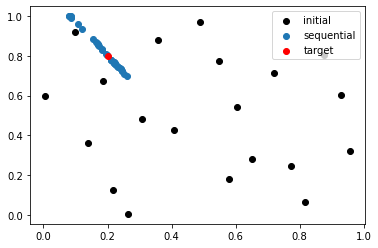

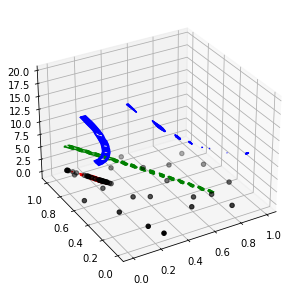

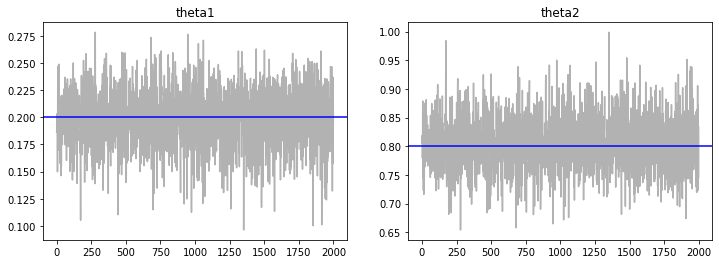

[array([[0.13865879, 0.91048496]]), array([[0.0480781]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[array([[0.14828051, 0.8895421 ]]), array([[0.04159083]])]
[array([[0.23775434, 0.73757018]]), array([[0.03786191]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[array([[0.17518811, 0.84629834]]), array([[0.03619296]])]
[array([[0.16028437, 0.87185412]]), array([[0.0342532]])]
[array([[0.16337675, 0.86618392]]), array([[0.03182289]])]
[array([[0.24281368, 0.72857392]]), array([[0.0296184]])]
[array([[0.17133815, 0.85253099]]), array([[0.02867821]])]
[array([[0.08983358, 1.        ]]), array([[0.02235713]])]
[array([[0.17210705, 0.85131192]]), array([[0.02580861]])]
[array([[0.2341588 , 0.74290483]]), array([[0.02577819]])]
[array([[0.23073771, 0.74885857]]), array([[0.02459396]])]
[array([[0.19388705, 0.81267663]]), array([[0.02385384]])]
[array([[0.1915149 , 0.81726834]]), array([[0.02389997]])]
[array([[0.17572201, 0.84449642]]), array([[0.02347737]])]
[array([[0.22486847, 0.75783896]]), array([[0.03048504]])]
[array([[0.20469687, 0.79360625]]), array([[0.03165087]])]
[array([[0.1938214 , 0.81149477]]), array([[0.03474204]])]
[array([[0.20915038, 0.78442049]]), array([[0.03559477]])]
[array([[0.18044818, 0.83348762]]), array([[0.03550287]])]

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

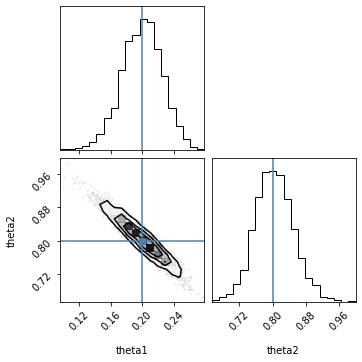

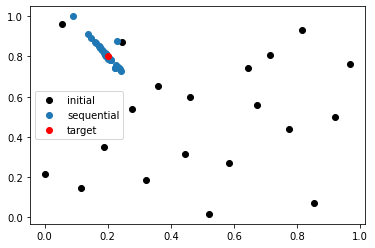

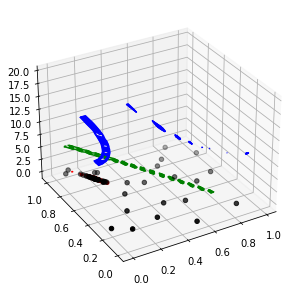

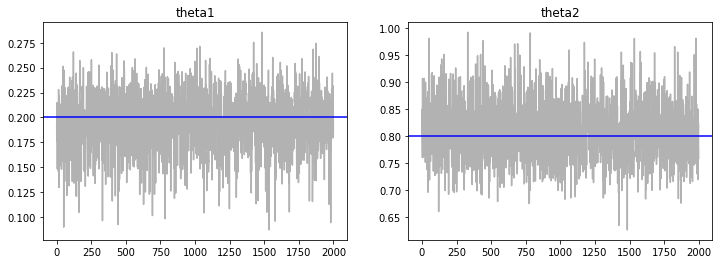

[array([[0.19177726, 0.79266169]]), array([[0.01234612]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[array([[0.07931058, 1.        ]]), array([[0.11177404]])]
[array([[0.2053168 , 0.81161367]]), array([[0.01065101]])]
[array([[0.19857543, 0.93877237]]), array([[1.88438111e-19]])]
[array([[0.21113844, 0.90635494]]), array([[9.48094387e-19]])]
[array([[0.22166325, 0.88314112]]), array([[5.56123669e-18]])]
[array([[0.21911842, 0.89456597]]), array([[8.82735593e-21]])]
[array([[0.19138439, 0.7999229 ]]), array([[0.02436677]])]
[array([[0.19018868, 0.7999725 ]]), array([[0.02265283]])]
[array([[0.18985568, 0.829645  ]]), array([[0.02136494]])]
[array([[0.19913036, 0.78714533]]), array([[0.02422848]])]
[array([[0.19399349, 0.79597051]]), array([[0.02349936]])]
[array([[0.2060382 , 0.77126124]]), array([[0.0134571]])]
[array([[0.20208861, 0.78528084]]), array([[0.0299355]])]
[array([[0.20992103, 0.76830326]]), array([[0.02180876]])]
[array([[0.19571296, 0.79628318]]), array([[0.0288648]])]
[array([[0.19687971, 0.79843997]]), array([[0.02796398]])]
[array([[0.19935595, 0.80657785]]), array([

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

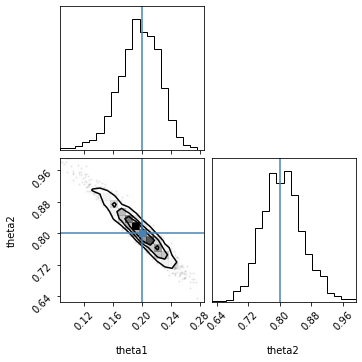

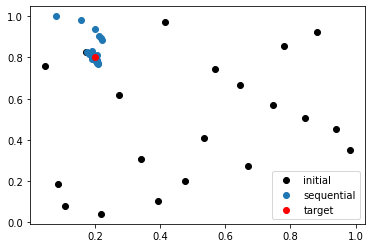

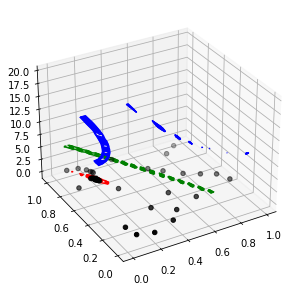

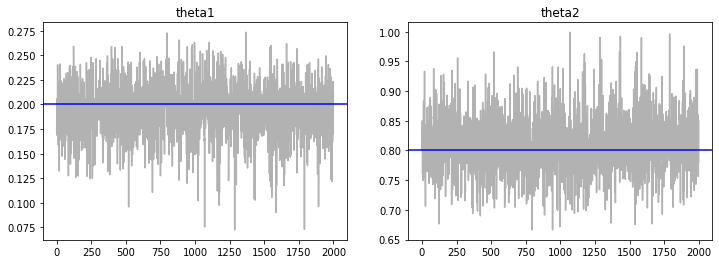

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


[array([[0.14977198, 0.89856031]]), array([[0.05330465]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[array([[0.15814824, 0.87818462]]), array([[0.04571734]])]
[array([[0.16823552, 0.85969599]]), array([[0.04102641]])]
[array([[0.16012602, 0.99304106]]), array([[1.17149798e-18]])]
[array([[0.21121415, 0.78592736]]), array([[0.03429362]])]
[array([[0.17258995, 0.86552454]]), array([[0.01169659]])]
[array([[0.18612253, 0.82751755]]), array([[0.03313709]])]
[array([[0.22721831, 0.75773719]]), array([[0.03641734]])]
[array([[0.22751426, 0.75790583]]), array([[0.03553586]])]
[array([[0.22001255, 0.77018201]]), array([[0.03543934]])]
[array([[0.20952091, 0.7808938 ]]), array([[0.03675379]])]
[array([[0.07950756, 0.99248154]]), array([[0.03029935]])]
[array([[0.21006872, 0.77724456]]), array([[0.0342076]])]
[array([[0.20524929, 0.78683889]]), array([[0.03602059]])]
[array([[0.21519331, 0.7661685 ]]), array([[0.02883257]])]
[array([[0.18716387, 0.83742846]]), array([[0.01628412]])]
[array([[0.20638108, 0.78342649]]), array([[0.02949403]])]
[array([[0.22918163, 0.73418568]]), array([[0.0085528

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[array([[0.19904707, 0.80323468]]), array([[0.03478812]])]
[array([[0.20966791, 0.78458654]]), array([[0.03388439]])]
[array([[0.20852377, 0.78640863]]), array([[0.03284152]])]
[array([[0.21455388, 0.76840791]]), array([[0.02479688]])]
[array([[0.19008252, 0.81507044]]), array([[0.03158215]])]
[array([[0.1957964 , 0.80744531]]), array([[0.03432885]])]
[array([[0.1992242 , 0.80483425]]), array([[0.03503476]])]
[array([[0.2097894 , 0.77704072]]), array([[0.03005431]])]
[array([[0.20187956, 0.79519237]]), array([[0.03455234]])]
[array([[0.20937084, 0.78454993]]), array([[0.03589769]])]
[array([[0.20883595, 0.78509098]]), array([[0.03645972]])]
[array([[0.1898732 , 0.81800767]]), array([[0.03558072]])]
[array([[0.21097413, 0.78121625]]), array([[0.0348162]])]
[array([[0.18960538, 0.81879641]]), array([[0.03535793]])]
[array([[0.21331848, 0.7772276 ]]), array([[0.03604033]])]
[array([[0.21026306, 0.78254405]]), array([[0.03525638]])]
[array([[0.21704415, 0.77059496]]), array([[0.03468095]])

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

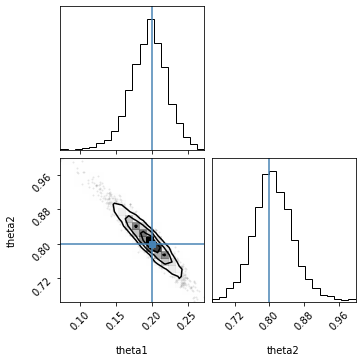

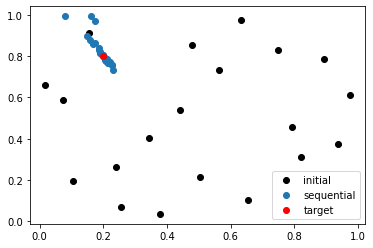

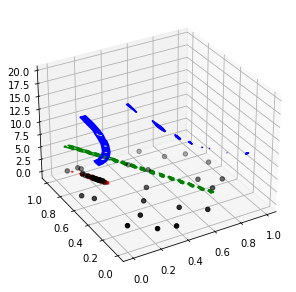

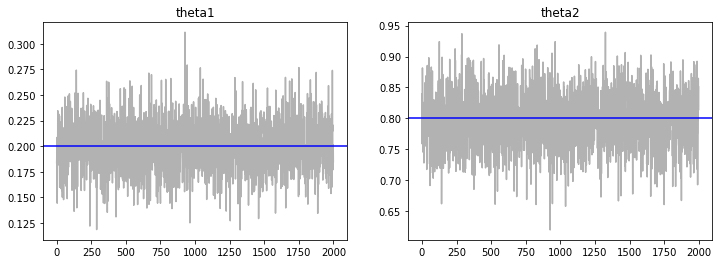

[array([[0.10184207, 0.96256375]]), array([[0.03771261]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[array([[0.11747411, 0.93466297]]), array([[0.02999507]])]
[array([[0.12490706, 0.92614317]]), array([[0.03198425]])]
[array([[0.12765618, 0.92339496]]), array([[0.03153409]])]
[array([[0.13087427, 0.91877954]]), array([[0.02917507]])]
[array([[0.20514532, 0.78814735]]), array([[0.02459882]])]
[array([[0.13503404, 0.91216128]]), array([[0.0266073]])]
[array([[0.25136517, 0.71196096]]), array([[0.02640006]])]
[array([[0.26482534, 0.68811234]]), array([[0.02513232]])]
[array([[0.2548479 , 0.70743466]]), array([[0.02764587]])]
[array([[0.18792386, 0.82288514]]), array([[0.02586071]])]
[array([[0.14678968, 0.89265228]]), array([[0.02587097]])]
[array([[0.19024866, 0.81888974]]), array([[0.0252296]])]
[array([[0.15570107, 0.87674696]]), array([[0.02529729]])]
[array([[0.15768568, 0.87336852]]), array([[0.02430276]])]
[array([[0.24481048, 0.72391787]]), array([[0.02531777]])]
[array([[0.18585175, 0.8255287 ]]), array([[0.02420501]])]
[array([[0.15947746, 0.86957258]]), array([[0.02411609]])]

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

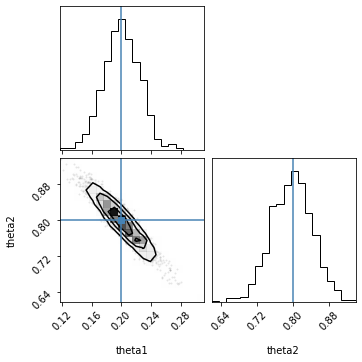

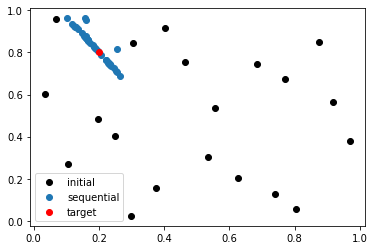

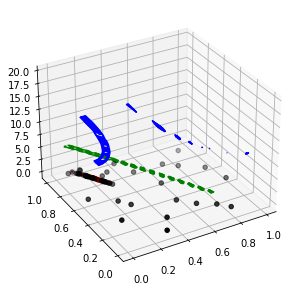

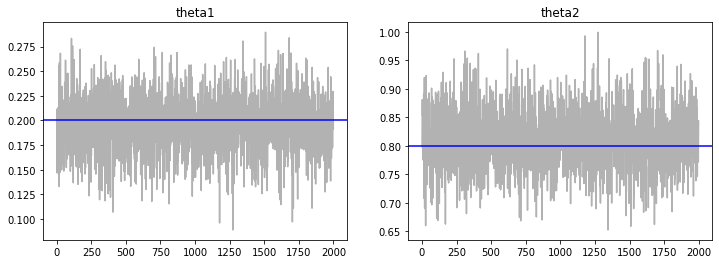

[array([[0.08619167, 1.        ]]), array([[0.07414704]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[array([[0.08558659, 1.        ]]), array([[0.04236356]])]
[array([[0.11443295, 0.94508299]]), array([[0.03794975]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[array([[0.14019975, 0.90242776]]), array([[0.03297663]])]
[array([[0.25920392, 0.69685547]]), array([[0.03141696]])]
[array([[0.24687543, 0.71786003]]), array([[0.02983738]])]
[array([[0.23896623, 0.73105183]]), array([[0.02860836]])]
[array([[0.20931573, 0.78375003]]), array([[0.03070779]])]
[array([[0.22832595, 0.75118758]]), array([[0.02947431]])]
[array([[0.16511359, 0.85983292]]), array([[0.02878675]])]
[array([[0.17535276, 0.84092541]]), array([[0.03293299]])]
[array([[0.22395673, 0.75738768]]), array([[0.03234314]])]
[array([[0.21477305, 0.87715695]]), array([[1.37667829e-20]])]
[array([[0.1693978 , 0.85061279]]), array([[0.03163685]])]
[array([[0.19641498, 0.80496992]]), array([[0.03018108]])]
[array([[0.2185111 , 0.76730867]]), array([[0.02956561]])]
[array([[0.17618218, 0.839633  ]]), array([[0.02863082]])]
[array([[0.19731412, 0.80401096]]), array([[0.02815005]])]
[array([[0.20905722, 0.89799274]]), array([[7.11508761e-23]])]
[array([[0.1866686 , 0.82291753]]), array([[0.03

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

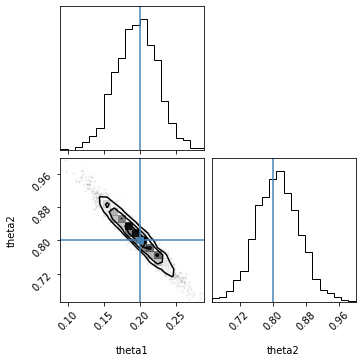

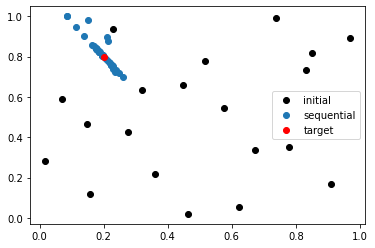

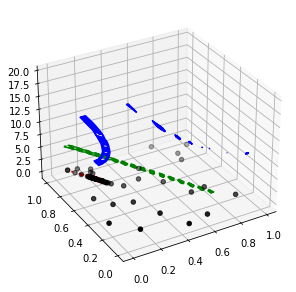

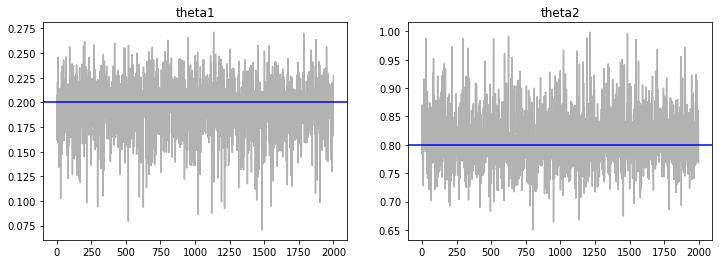

[array([[0.1157132 , 0.94809738]]), array([[0.09720896]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[array([[0.13365714, 0.92070255]]), array([[0.05756391]])]
[array([[0.13837071, 0.90884861]]), array([[0.05537521]])]
[array([[0.14482482, 0.89112364]]), array([[0.06582246]])]
[array([[0.21875431, 0.74665673]]), array([[0.034703]])]
[array([[0.18221074, 0.82851465]]), array([[0.0615368]])]
[array([[0.1916644, 0.8033591]]), array([[0.04861527]])]
[array([[0.1962137 , 0.79500492]]), array([[0.04423898]])]
[array([[0.19023207, 0.82727537]]), array([[0.03545244]])]
[array([[0.19247605, 0.79873436]]), array([[0.03711845]])]
[array([[0.1918275 , 0.79892921]]), array([[0.03265453]])]
[array([[0.18895934, 0.83168254]]), array([[0.02894597]])]
[array([[0.18952088, 0.79952652]]), array([[0.02790728]])]
[array([[0.18875114, 0.80149316]]), array([[0.02724263]])]
[array([[0.19479062, 0.82044074]]), array([[0.0304074]])]
[array([[0.19475672, 0.82072926]]), array([[0.02826332]])]
[array([[0.19629857, 0.81576098]]), array([[0.0326852]])]
[array([[0.19730649, 0.78922867]]), array([[0.03129968]])]
[arr

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

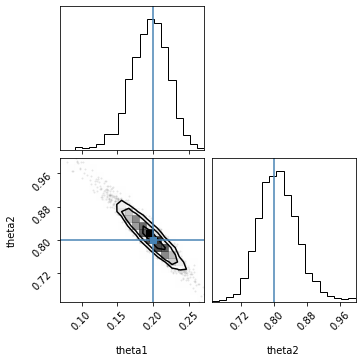

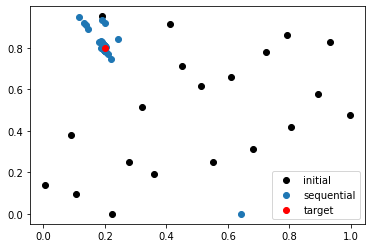

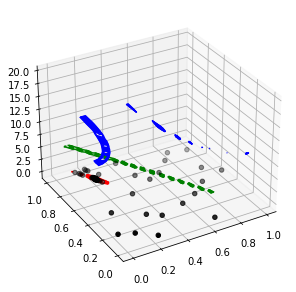

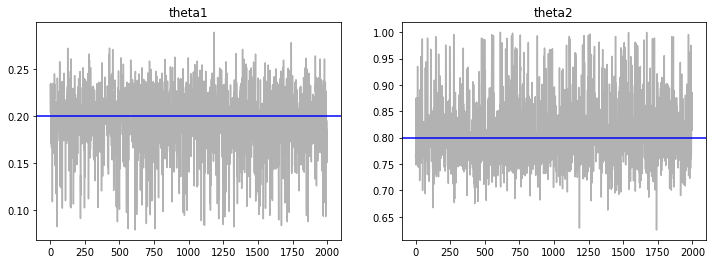

[array([[0.08358483, 1.        ]]), array([[0.06214282]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[array([[0.08054352, 1.        ]]), array([[0.04105095]])]
[array([[0.07836824, 1.        ]]), array([[0.03511628]])]
[array([[0.28255357, 0.65123705]]), array([[0.0277109]])]
[array([[0.11749184, 0.93617616]]), array([[0.0303429]])]
[array([[0.15096923, 0.88191201]]), array([[0.02943425]])]
[array([[0.26711978, 0.68079314]]), array([[0.0278199]])]
[array([[0.28312598, 0.74664132]]), array([[1.21952147e-20]])]
[array([[0.20318669, 0.79253455]]), array([[0.0246848]])]
[array([[0.25629793, 0.69997083]]), array([[0.0236516]])]
[array([[0.25375172, 0.7049679 ]]), array([[0.02304011]])]
[array([[0.15926832, 0.86915106]]), array([[0.02643005]])]
[array([[0.25046981, 0.71193789]]), array([[0.02525537]])]
[array([[0.2238392, 0.7581843]]), array([[0.02435141]])]
[array([[0.18339932, 0.91494203]]), array([[2.96677614e-19]])]
[array([[0.16745227, 0.85544609]]), array([[0.02277499]])]
[array([[0.25820281, 0.69781008]]), array([[0.02235513]])]
[array([[0.22218601, 0.76130382]]), array([[0.02245394]

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

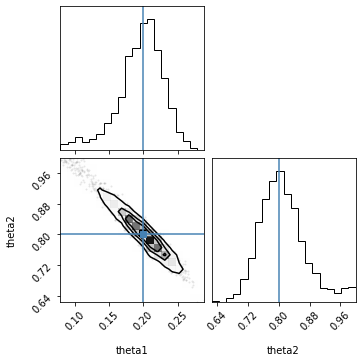

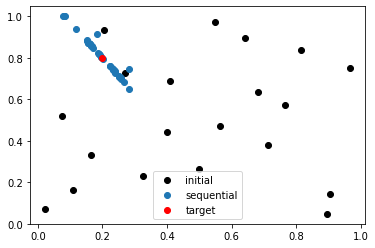

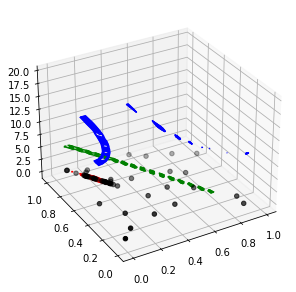

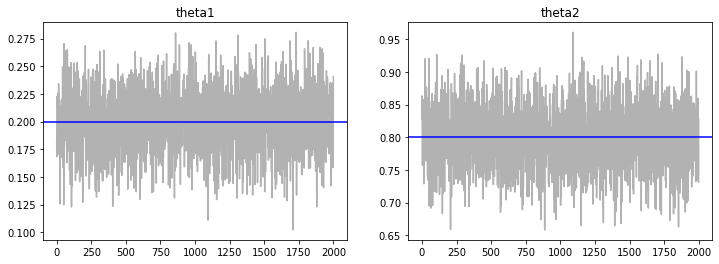

[array([[0.11841868, 0.95657955]]), array([[0.05028085]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[array([[0.12323165, 0.94586341]]), array([[0.04020342]])]
[array([[0.12542447, 0.94309047]]), array([[0.03577655]])]
[array([[0.12968934, 0.93676638]]), array([[0.03227327]])]
[array([[0.13176924, 0.93003999]]), array([[0.03077654]])]
[array([[0.13546292, 0.9199087 ]]), array([[0.03862838]])]
[array([[0.17493975, 0.84881432]]), array([[0.03560728]])]
[array([[0.14492922, 0.90198139]]), array([[0.03503028]])]
[array([[0.14791885, 0.89746188]]), array([[0.03417115]])]
[array([[0.22050912, 0.7547391 ]]), array([[0.01957841]])]
[array([[0.2214851 , 0.76403024]]), array([[0.03183874]])]
[array([[0.15664635, 0.88859251]]), array([[0.02353356]])]
[array([[0.22578791, 0.75586871]]), array([[0.02961846]])]
[array([[0.17249006, 0.96413072]]), array([[1.06123751e-22]])]
[array([[0.22145928, 0.76277694]]), array([[0.02885136]])]
[array([[0.16932462, 0.85599232]]), array([[0.03223667]])]
[array([[0.21679157, 0.76952789]]), array([[0.0317761]])]
[array([[0.21600836, 0.77035708]]), array([[0.0315825

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

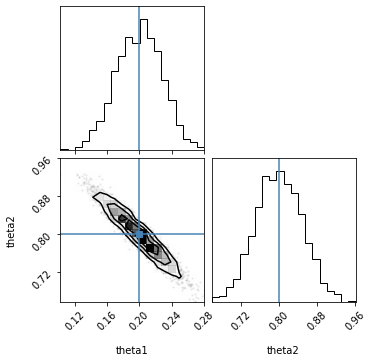

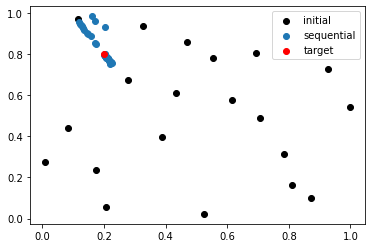

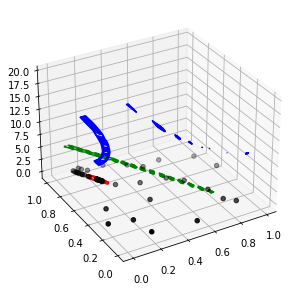

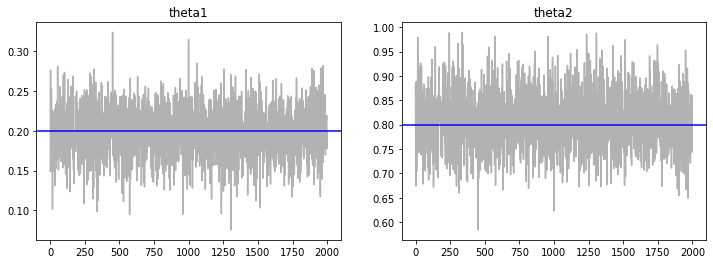

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[array([[0.17978343, 0.83039631]]), array([[0.041526]])]


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[array([[0.20023924, 0.79225513]]), array([[0.02729624]])]
[array([[0.20331754, 0.80848901]]), array([[0.02329917]])]
[array([[0.20391912, 0.80784102]]), array([[0.01820046]])]
[array([[0.07320133, 0.99281527]]), array([[0.01655071]])]
[array([[0.20065039, 0.78871931]]), array([[0.0176387]])]
[array([[0.20682126, 0.77895817]]), array([[0.01873092]])]
[array([[0.19535953, 0.80034053]]), array([[0.02044531]])]
[array([[0.21226731, 0.76531612]]), array([[0.00866788]])]
[array([[0.21186318, 0.76832871]]), array([[0.0141529]])]
[array([[0.19548238, 0.80064289]]), array([[0.02538324]])]
[array([[0.20117206, 0.79054632]]), array([[0.02511395]])]
[array([[0.19381253, 0.80630305]]), array([[0.02596526]])]
[array([[0.19379548, 0.82582188]]), array([[0.02683234]])]
[array([[0.18882315, 0.83509736]]), array([[0.02508876]])]
[array([[0.19511141, 0.82400665]]), array([[0.02517291]])]
[array([[0.19562217, 0.8234664 ]]), array([[0.02386664]])]
[array([[0.1931191 , 0.82325324]]), array([[0.03201507]])]

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

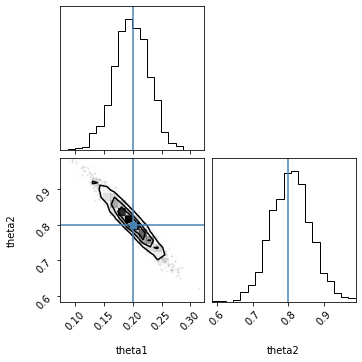

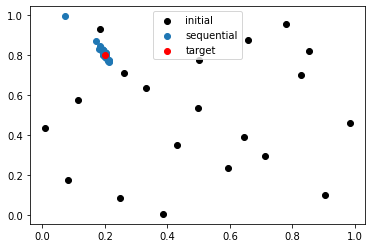

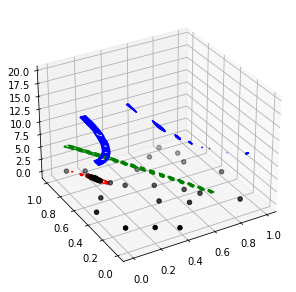

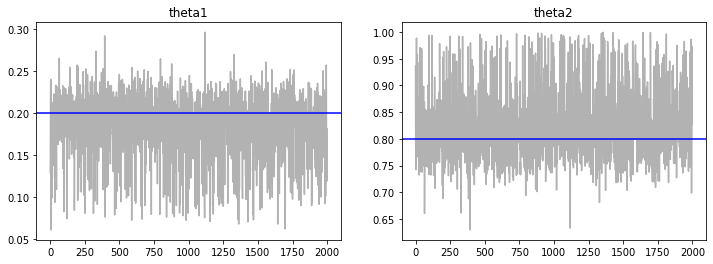

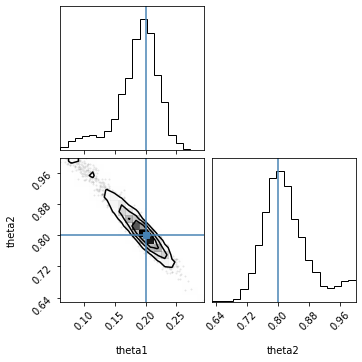

In [11]:
for runNo in range(10):
    # initial points and initialize emulator
    X = lhs(n=2, samples=n_init, criterion='maximin', iterations=20)
    X[:,0] = (ub[0]-lb[0])*X[:,0]+lb[0]
    X[:,1] = (ub[1]-lb[1])*X[:,1]+lb[1]
    Y = f(X)
    max_iterations = n_total - len(X)

    kernel1 = RBF(input_dim=2)
    kernel2 = RBF(input_dim=2)
    model_gpy = MultioutputGP([X,X],Y,
                              likelihood_list=[likelihoods.Gaussian(variance=noise,name='Gaussian_noise'),
                                               likelihoods.Gaussian(variance=noise,name='Gaussian_noise')],
                              kernel_list=[kernel1,kernel2])
    model_emukit = GPyMultiOutputWrapper(model_gpy, n_outputs=2, n_optimization_restarts=10, verbose_optimization = False)
    model_emukit.optimize()

    contour_MD = contourMinEI(modelwrapper = model_emukit, a_list = a_list, alpha_list = alpha_list, w_list = w_list)
    expdesign_loop = ExperimentalDesignLoop(model = model_emukit,
                                             space = parameter_space,
                                             acquisition = contour_MD,
                                             batch_size = 1)

    #---# loop to generate designs
    for i in range(0,max_iterations):  
        # Compute next point
        optimizer = GradientAcquisitionOptimizer(parameter_space)
        xnew, opt_acq = optimizer.optimize(contour_MD)

        print([xnew,opt_acq])
        X0 = np.append(X[:,0],xnew[:,0])
        X1 = np.append(X[:,1],xnew[:,1])
        X = np.array([X0,X1]).transpose()
        y1 = np.append(Y[0],f(xnew)[0]).reshape(-1,1)
        y2 = np.append(Y[1],f(xnew)[1]).reshape(-1,1)
        Y = [y1,y2]
        model_gpy = MultioutputGP([X,X],Y,
                              likelihood_list=[likelihoods.Gaussian(variance=noise,name='Gaussian_noise'),
                                               likelihoods.Gaussian(variance=noise,name='Gaussian_noise')],
                              kernel_list=[kernel1,kernel2])
        model_emukit = GPyMultiOutputWrapper(model_gpy, n_outputs=2, n_optimization_restarts=10, verbose_optimization = False)
        model_emukit.optimize()
        contour_MD = contourMinEI(modelwrapper = model_emukit, a_list = a_list, alpha_list = alpha_list, w_list = w_list)
    
    #---# plot final samples
    n_end = len(X)
    fig, ax = plt.subplots()
    ax.scatter(X[0:n_init,0],X[0:n_init,1], color='black', label='initial')
    ax.scatter(X[n_init:n_end,0],X[n_init:n_end,1], label='sequential')
    ax.scatter(true_param[:,0], true_param[:,1], color='red', label='target')
    n = np.arange(0,X[0:n_end,:].shape[0])
    # for i, txt in enumerate(n):
    #     ax.annotate(txt, (X[i,0], X[i,1]))
    plt.legend()

    #---# plot contours
    fig = plt.figure(figsize = (5,5))
    ax = fig.gca(projection='3d')
    A = np.linspace(0, 1, 30)
    B = np.linspace(0, 1, 30)
    A, B = np.meshgrid(A, B)

    # ax.plot_surface(A, B, l(A,B), rstride=1, cstride=1, cmap = cm.viridis, antialiased=False, alpha = 0.5)
    # ax.plot_surface(A, B, g(A,B), rstride=1, cstride=1, cmap = cm.viridis, antialiased=False, alpha = 0.5)
    ax.contour(A, B, abs(l(A,B)-l(true_param[0][0],true_param[0][1])), levels=list(np.linspace(0,0.1,10)), zdir='z', offset=10, colors='blue')
    ax.contour(A, B, abs(g(A,B)-g(true_param[0][0],true_param[0][1])), levels=list(np.linspace(0,0.3,10)), zdir='z', offset=5, colors='green')
    ax.contour(A, B, abs(l(A,B)-l(true_param[0][0],true_param[0][1]))+abs(g(A,B)-g(true_param[0][0],true_param[0][1])), levels=list(np.linspace(0,0.5,10)), zdir='z', offset=0, colors='red')
    ax.scatter(X[:,0], X[:,1], np.zeros(X.shape[0]), color='black') 
    ax.view_init(30, 240)

    #---# Bayesian inference
    X_final = X[0:n_end,:]
    Y_final = f(X_final)
    
    kernel1 = RBF(input_dim=2)
    kernel2 = RBF(input_dim=2)
    model_gpy = MultioutputGP([X_final,X_final],Y_final,
                              likelihood_list=[likelihoods.Gaussian(variance=noise,name='Gaussian_noise'),
                                               likelihoods.Gaussian(variance=noise,name='Gaussian_noise')],
                              kernel_list=[kernel1,kernel2])
    model = GPyMultiOutputWrapper(model_gpy, n_outputs=2, n_optimization_restarts=20, verbose_optimization = False)
    model.optimize()
    
    def emu_predict(xx, obsno):
        """This function handles the scaling and GP interpolation together, 
        returning our prediction in the ordinary observable space
        rather than the scaled observable space.
        This map is what we call our 'emulator'. """
        X = xx.reshape(-1, ndim)
        new_column = [[obsno]]*len(X)
        pred_temp = model.predict(np.append(X,new_column,axis=1))
        y = pred_temp[0] # vector of predictive means
        s2_vec = pred_temp[1]
        dy = np.sqrt(s2_vec)
        return y, dy

    def log_likelihood(theta, y_exp, dy_exp):
        '''Log-likelihood for data y_exp.'''
        #use our GP emulator for prediction
        log_lik = 0

        for obs in range(y_exp.shape[1]): # number of observables
            y_pred, s_pred = emu_predict(theta, obs) # emulation prediction and uncertainty
            sigma2 = s_pred**2. + dy_exp.flatten()[obs]**2. #total variance, emulation and exp.
            log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) -0.5*( (y_pred - y_exp.flatten()[obs])**2 / sigma2 )

        return log_lik

    #posterior using flat prior
    def log_posterior_flat_prior(theta, y_exp, dy_exp):
        '''Log posterior for data y_exp and uncertainties 
            dy_exp given parameter array theta, assuming prior is flat.'''
        return log_flat_prior(theta) + log_likelihood(theta, y_exp, dy_exp)
    
    # ptemcee
    ntemps = 2
    nwalkers = 20
    # starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
    starting_guesses = np.random.uniform(size=(ntemps,nwalkers,ndim))
    sampler = PTSampler(nwalkers, ndim, log_likelihood, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp])

    # burn in
    for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=5000):
        pass
    sampler.reset()

    # record every 10
    for p, lnprob, lnlike in sampler.sample(p, iterations=1000, thin=10):
        pass

    # resulting chains
    assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

    # Chain has shape (ntemps, nwalkers, nsteps, ndim)
    # Zero temperature mean:
    mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

    # Longest autocorrelation length (over any temperature)
    max_acl = np.max(sampler.acor)
    
    # plots & save data for R analysis
    prop_T0chain = sampler.chain[0,...].reshape(-1,ndim)
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(prop_T0chain[:,0], '-', color='k', alpha=0.3)
    ax1.axhline(y=true_param[0][0], color='blue')
    ax1.title.set_text('theta1')

    ax2.plot(prop_T0chain[:,1], '-', color='k', alpha=0.3)
    ax2.axhline(y=true_param[0][1], color='blue')
    ax2.title.set_text('theta2')
    plt.show()

    tmp = corner.corner(prop_T0chain, labels=['theta1','theta2'], 
                    truths=[true_param[0][0],true_param[0][1]])

    MCMC_sim = pd.DataFrame(prop_T0chain)
    MCMC_sim.to_csv('2d_2obs_Branin_LIM_MCMCprop'+str(runNo)+'.csv', index=False)
    

### 3. Random LHD Designs

#### Repeat 10 times

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

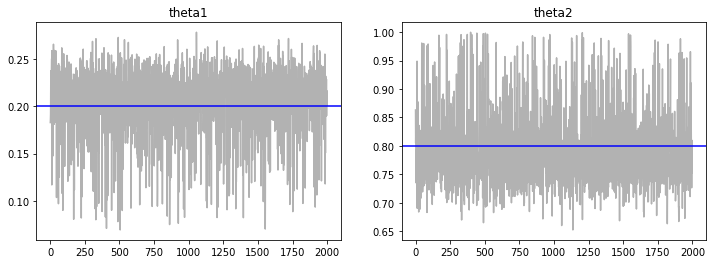

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

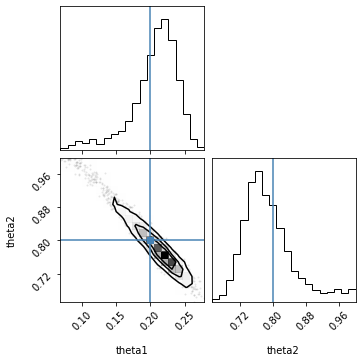

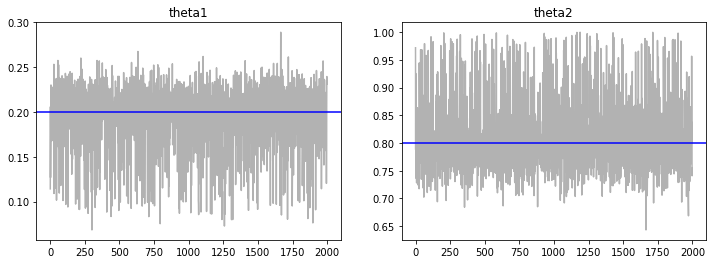

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

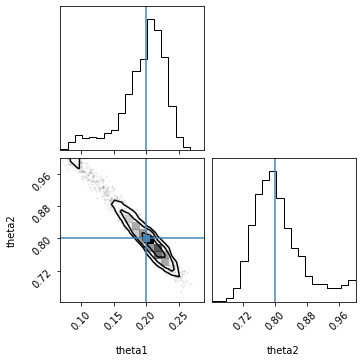

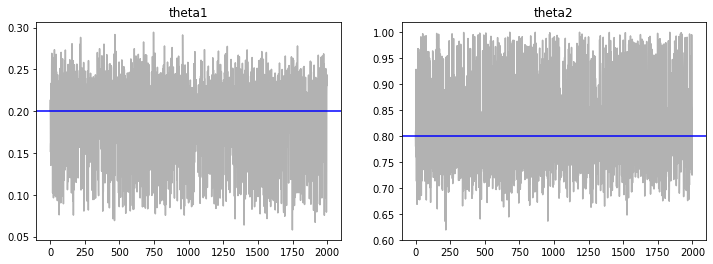

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

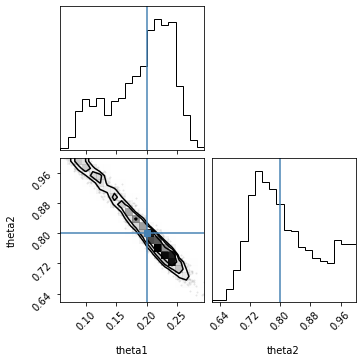

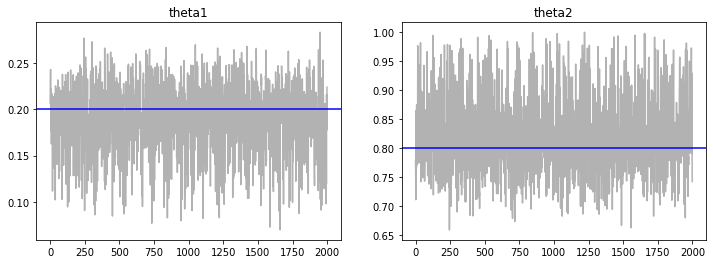

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

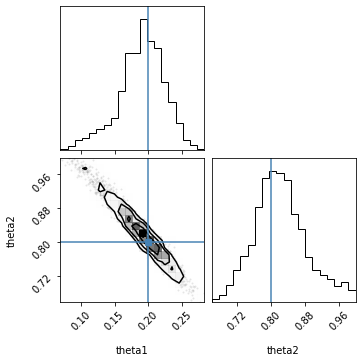

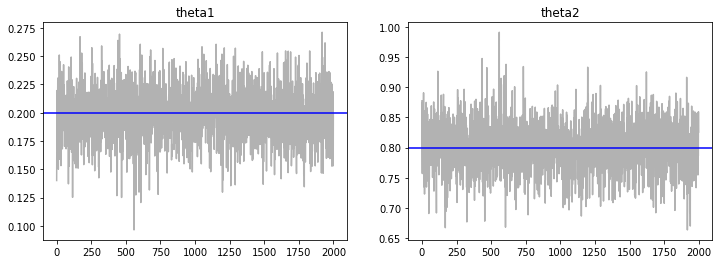

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

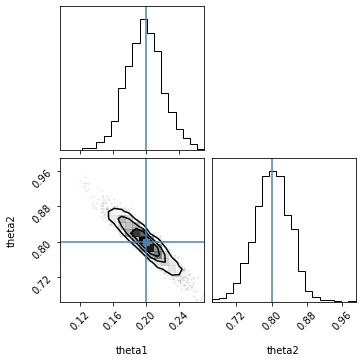

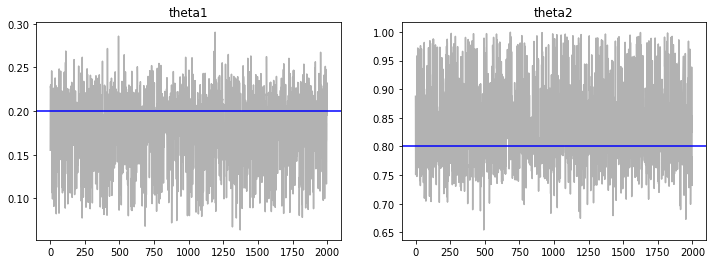

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

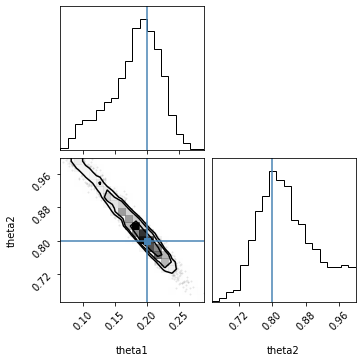

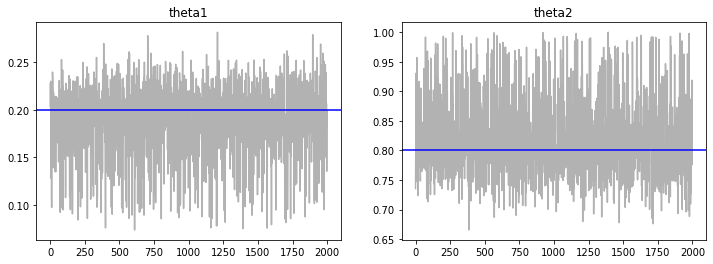

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

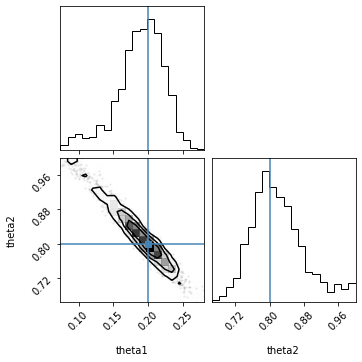

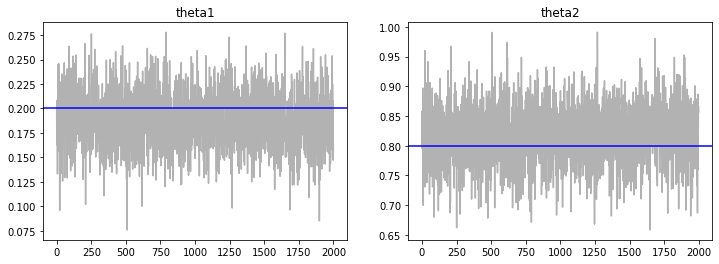

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

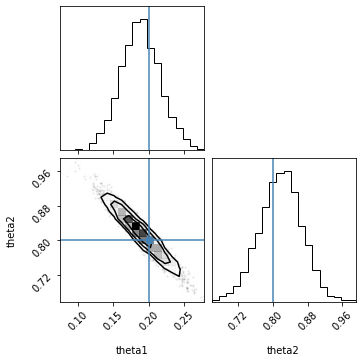

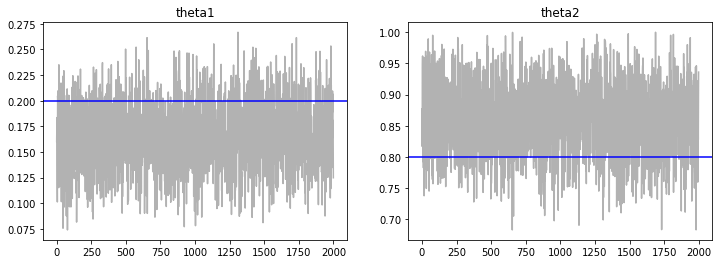

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

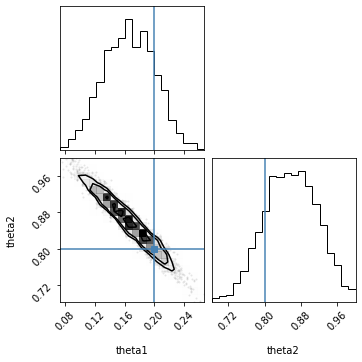

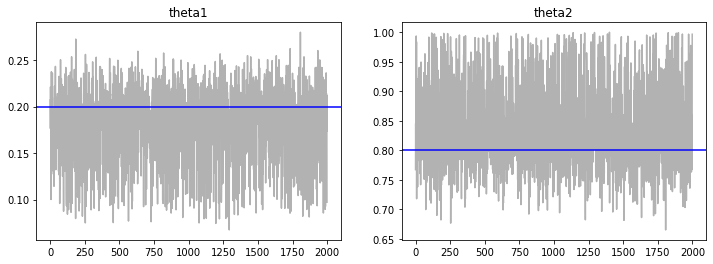

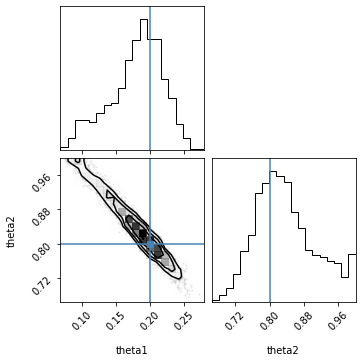

In [12]:
for runNo in range(10):
    x_ref = lhs(n=2, samples=n_total) # no criterion specified: random design
    y_ref = f(x_ref)
    
    # train GP
    kernel1 = RBF(input_dim=2)
    kernel2 = RBF(input_dim=2)
    model_gpy = MultioutputGP([x_ref,x_ref],y_ref,
                              likelihood_list=[likelihoods.Gaussian(variance=noise,name='Gaussian_noise'),
                                               likelihoods.Gaussian(variance=noise,name='Gaussian_noise')],
                              kernel_list=[kernel1,kernel2])
    model_ref = GPyMultiOutputWrapper(model_gpy, n_outputs=2, n_optimization_restarts=20, verbose_optimization = False)
    model_ref.optimize()
    
    def emu_ref_predict(xx, obsno):
        """This function handles the scaling and GP interpolation together, 
        returning our prediction in the ordinary observable space
        rather than the scaled observable space.
        This map is what we call our 'emulator'. """
        X = xx.reshape(-1, ndim)
        new_column = [[obsno]]*len(X)
        pred_temp = model_ref.predict(np.append(X,new_column,axis=1))
        y = pred_temp[0] # vector of predictive means
        s2_vec = pred_temp[1]
        dy = np.sqrt(s2_vec)
        return y, dy
    
    # define log likelihood
    def log_likelihood_ref(theta, y_exp, dy_exp):
        '''Log-likelihood for data y_exp.'''
        #use our GP emulator for prediction
        log_lik = 0

        for obs in range(y_exp.shape[1]): # number of observables
            y_pred, s_pred = emu_ref_predict(theta, obs) # emulation prediction and uncertainty
            sigma2 = s_pred**2. + dy_exp.flatten()[obs]**2. #total variance, emulation and exp.
            log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) -0.5*( (y_pred - y_exp.flatten()[obs])**2 / sigma2  )

        return log_lik
    
    #posterior using flat prior
    def log_posterior_flat_prior_ref(theta, y_exp, dy_exp):
        '''Log posterior for data y_exp and uncertainties 
            dy_exp given parameter array theta, assuming prior is flat.'''
        return log_flat_prior(theta) + log_likelihood_ref(theta, y_exp, dy_exp)

    
    # ptemcee
    # https://emcee.readthedocs.io/en/develop/user/pt/
    from emcee.ptsampler import PTSampler
    ntemps = 2
    nwalkers = 20
    # starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
    starting_guesses = np.random.uniform(size=(ntemps,nwalkers,ndim))
    sampler = PTSampler(nwalkers, ndim, log_likelihood_ref, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp])

    # burn in
    for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=5000):
        pass
    sampler.reset()

    # record every 10
    for p, lnprob, lnlike in sampler.sample(p, iterations=1000, thin=10):
        pass

    # resulting chains
    assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

    # Chain has shape (ntemps, nwalkers, nsteps, ndim)
    # Zero temperature mean:
    mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

    # Longest autocorrelation length (over any temperature)
    max_acl = np.max(sampler.acor)
    
    
    # plots & save data for R analysis
    LHD_T0chain = sampler.chain[0,...].reshape(-1,ndim)
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(LHD_T0chain[:,0], '-', color='k', alpha=0.3)
    ax1.axhline(y=true_param[0][0], color='blue')
    ax1.title.set_text('theta1')

    ax2.plot(LHD_T0chain[:,1], '-', color='k', alpha=0.3)
    ax2.axhline(y=true_param[0][1], color='blue')
    ax2.title.set_text('theta2')
    plt.show()

    tmp = corner.corner(LHD_T0chain, labels=['theta1','theta2'], 
                    truths=[true_param[0][0],true_param[0][1]])
    
    MCMC_LHD = pd.DataFrame(LHD_T0chain)
    MCMC_LHD.to_csv('2d_2obs_Branin_LIM_MCMCLHD'+str(runNo)+'.csv', index=False)
    